In [1180]:
import scipy
import numpy as np
import scipy.signal
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import matplotlib

In [232]:
class Board:
    
    def __init__(self, board_size = 100, oecosystema = [1000,100,10]):
        self.board_size = board_size
        self.board = np.zeros((board_size, board_size), dtype = int)
        self.oecosystema = oecosystema
        self.number_of_species = len(oecosystema)
        self.neighbourhood = np.array([[0,1,0],[1,0,1],[0,1,0]])
        self.populate_board(oecosystema)
        self.bound = 'wrap'
        
        
    def populate_board(self, oecosystema = [1000,100,10]):
        """
        Metoda, która zaludnia self.board agentami różnych gatunków. 
        Kolor gatunku (int) to jego pozycja na liście plus jeden.
        
        :param oecosystema: (int list) liczebności gatunków od stojącego najwyżej w łańcuchu 
        pokarmowym do tych stojących najwyżej
        """
        coordinates = np.unique(np.random.randint(self.board_size, size = (4*sum(oecosystema), 2)), axis = 0)
        while coordinates.shape[0] < sum(oecosystema):
            np.unique(np.concatenate( (coordinates, np.random.randint(self.board_size, size = 2)),axis=0), axis = 0)
        np.random.shuffle(coordinates)
        i = 0
        j = 0
        for species in oecosystema:
            j+=1
            for zoon in range(species):
                self.board[coordinates[i,0], coordinates[i,1]] = j
                i+=1
                
    def neighbours(self, neighbour_colours):
        """
        Metoda, która zwraca kopię self.board, na której pozostawiamy tylko gatunki wymienione w parametrze
        neighbour_colours
        
        :param neighbour_colours: (int list) numery kolorów, które chcemy pozostawić na planszy
        :return: (2d array) kopia self.board, na której zerujemy wszystkie kolory poza neigbbour_colours
        """
        delete = [c for c in range(1,self.number_of_species+1) if c not in neighbour_colours]
        neighbours = self.monochromatic_board(delete)
        return neighbours
    
    def monochromatic_board(self, colours):
        """
        Metoda, która zwraca kopię self.board, w której pozostają tylko kolory poza colours
        
        :param colours: (int list) kolory do usunięcia
        :return: (2d array) kopia self.board, na której zerujemy wszystkie kolory poza colours
        """
        new_board = np.array(self.board, copy = True)
        for c in colours:
            new_board[new_board == c] = 0
        return new_board
    
    def compute_neighbours(self, neighbour_colours, neighbourhood = np.array([[0,1,0],[1,0,1],[0,1,0]])):
        """
        Metoda zwracające macierz o rozmiarach identycznych jak self.board, na której w (i,j) 
        komórce znajduje się liczba sąsiadów o jednej z barw z neighbour_colours.
        
        
        """
        A = self.neighbours(neighbour_colours).astype(bool)
        return scipy.signal.convolve2d(A, neighbourhood, mode = 'same',  boundary = self.bound)
    
    def get_oecosystema():
        return self.oecosystema

In [1262]:
class LotkaVolterra:
    
    def __init__(self, board_size = 30,
                oecosystema = [80,10,4], #początkowe liczebności
                reprod = [0.04, 0.95, 0.99], #prawd. reprodukcji
                mortality = [0.0, 0.02, 0.01], #prawd. śmierci
                predator = [[], [1], [1,2]],#na co poluje
                radius = 3, #promień, w jakim odbywa się polowanie
                freq = 0.1,#cz¢ęstotliwość polowań
                hunted = [1], # na co polują myśliwi
                hunt_level = [400,0,0] #poziom populacji, od której zaczynają się polowania. długość taka jak oecosystema
                hmethod = 'freq2'): #metoda polowań
        self.board = Board(board_size = board_size, oecosystema = oecosystema)
        self.reprod = reprod
        self.mortality = mortality
        self.predator = predator
        self.alive = sum(oecosystema)
        self.randoms = np.random.randint( low = 0, high = 5, size = self.alive)
        self.current = 0
        self.check_input()
        self.prey = self.compute_prey()
        self.history = []
        self.radius = radius
        self.freq = freq
        self.hmethod = hmethod
        self.hunted = hunted
        self.hunt_level = hunt_level
        self.diversity = len(self.board.oecosystema)
        for i in range(self.diversity):
            self.history.append([self.board.oecosystema[i]])
        self.steps = 0
        self.huntings = []
        self.huntedpr = []
        
        
        
    def check_input(self):
        while len(self.board.oecosystema) > len(self.reprod):
            self.reprod.append(self.reprod[-1])
        while len(self.board.oecosystema) > len(self.mortality):
            self.mortality.append(self.mortality[-1])
        i = len(self.predator)
        while len(self.board.oecosystema) > len(self.predator):
            L = self.predator[-1].copy()
            L.append(i)
            i += 1
            self.predator.append(L)       
            
            
    def reproduce(self, colour, x_coord, y_coord, reprod):
        """
        Metoda zaludniająca self.board.board z prawdopodobieństwem reprod komórkę koloru colour 
        o współrzędnych x_coord, y_coord. Jednocześnie metoda zwiększa liczebność gatunku colour
        w self.board.oecosystema o 1.
        
        :param colour: kolor komórki do rozmnożenia
        :param x_coord: pierwsza współrzędna komórki, w której chcemy umieści nowe żyjątko
        :param y_coord: druga współrzędna komórki, w której chcemy umieści nowe żyjątko
        :param reprod: prawdopodobieństwo zaistnienia żyjątka
        """
        if np.random.uniform() < reprod:
            self.board.board[x_coord, y_coord] = colour
            self.board.oecosystema[colour-1] += 1
    
    def compute_prey(self):
        """
        Metoda, ktra na podstawie self.predator oblicza self.prey, czyli kto poluje na (indeks listy+1)
        """
        pr = self.predator
        pry = []
        for i in range(1,len(pr)+1):
            pryc = []
            for p in range(len(pr)):
                if i in pr[p]:
                    pryc.append(p+1)
            pry.append(pryc)
        return pry
    
    def kill_prey(self, my_colour, neighbours, predator):
        #my_colour = self.board.board[coords[0],coords[1]]
        for n in neighbours:
            if n[2] in predator[my_colour-1]:
                self.board.board[n[0],n[1]] = 0
                self.board.oecosystema[ n[2] ] -= 1
                self.reproduce(my_colour, n[0], n[1])
        
    def die(self, colour, x_coord, y_coord, mortality):
        if np.random.uniform() < mortality[colour-1]:
            self.board.board[x_coord, y_coord] = 0
            
    def move(self, colour, x_coord, y_coord):        
        if (self.randoms[self.current % self.alive] == 1 and
            self.board.board[(x_coord+1)%self.board.board_size, y_coord ] == 0): #E
            self.board.board[(x_coord+1)%self.board.board_size, y_coord ] = colour
            self.board.board[x_coord%self.board.board_size, y_coord ] = 0
        elif (self.randoms[self.current % self.alive] == 2 and 
            self.board.board[(x_coord-1)%self.board.board_size, y_coord ] == 0): #W
            self.board.board[(x_coord-1)%self.board.board_size, y_coord ] = colour
            self.board.board[x_coord%self.board.board_size, y_coord ] = 0
        elif (self.randoms[self.current % self.alive] == 3 and #S
            self.board.board[x_coord, (y_coord-1)%self.board.board_size  ] == 0):
            self.board.board[x_coord, (y_coord-1)%self.board.board_size ] = colour
            self.board.board[x_coord%self.board.board_size, y_coord ] = 0            
        elif (self.randoms[self.current % self.alive] == 4 and #N
            self.board.board[x_coord, (y_coord+1)%self.board.board_size  ] == 0):
            self.board.board[x_coord, (y_coord+1)%self.board.board_size ] = colour
            self.board.board[x_coord%self.board.board_size, y_coord ] = 0
        self.current += 1
    
    def check_neighbours(self, coords):       
        neighbours = []
        B = self.board.neighbourhood
        X = int(len(B)/2)
        for x in B:
            Y = int(len(B[0])/2)
            for y in x:
                if(y):
                    if(self.board.board[ (coords[0]+X)%self.board.board_size,
                                        (coords[1]+Y)%self.board.board_size]):
                        neighbours.append( ( (coords[0]+X)%self.board.board_size, 
                                            (coords[1]+Y)%self.board.board_size, 
                                            self.board.board[(coords[0]+X)%self.board.board_size,
                                                             (coords[1]+Y)%self.board.board_size] ) )
                Y-=1
            X-=1
        return neighbours

    def coord_2_matrix(self,coords):
        """
        Metoda przerabiająca listę koordynat na macierz
        """
        bd = np.zeros((self.board.board_size,self.board.board_size), dtype = int)
        for sp in range(len(self.board.oecosystema)):
            for co in range(len(coords[sp])):
                bd[coords[sp][co][0],coords[sp][co][1]] = sp+1
        return bd
                
    
    def compute_eats(self):
        preys = []
        for spec in range(1,len(self.board.oecosystema)+1):
            preys.append(self.board.compute_neighbours(self.predator[spec-1]))
            #print(spec,"predator:",self.predator[spec-1])
            #print(spec,"preys:\n", preys[spec-1].astype(int))
        return preys
    
    def predate(self):
        preds = []     
        coords = []
        for spec in range(1,len(self.board.oecosystema)+1):
                preds.append(self.board.compute_neighbours(self.prey[spec-1]).astype(bool))
                coords.append(self.board.neighbours([spec]))
                #print("spec:",spec)
                #print("coords:\n", coords[spec-1])
                #print("preds:\n",preds[spec-1].astype(int))
                #zabijanie ofiar
                prey_kill = np.logical_and(coords[spec-1],preds[spec-1])
                #print(spec," suma ofiar:",sum(sum(prey_kill)),"\n")
                self.board.board = self.board.board - spec * prey_kill
                self.board.oecosystema[spec-1] = self.board.oecosystema[spec-1] - sum(sum(prey_kill))
                #print("board:\n",self.board.board,"\n_____________________\n")
        
     
    def die2(self):
        list_of_coords = []
    #listy koordynat
        for spec in range(1,len(self.board.oecosystema)+1):
            coords2 = self.board.neighbours([spec])
            list_of_coords.append(np.transpose(np.nonzero(coords2)).tolist())
            #print(np.transpose(np.nonzero(coords2)).tolist())
            #list_of_coords.append(csr_matrix(coords2))
            alive_len = self.board.oecosystema[spec-1]
            die = np.random.binomial(1,1-self.mortality[spec-1],alive_len).astype(bool)
            #print(spec," die:",die)
            list_of_coords[spec-1] = np.array(list_of_coords[spec-1])[np.array(die)] 
            #aktualizacja ekosystemu
            self.board.oecosystema[spec-1] = sum(die)
        #print("die: loc ", list_of_coords)
        bd = self.coord_2_matrix(list_of_coords)
        #self.spasiba = list_of_coords
        #print("die2: bd\n",bd,"\n")
        self.board.board = bd #aktualizacja self.board.board
        #print(list_of_coords)
        return list_of_coords

    def dye_coord(self,x,y):
        r = np.random.randint(low=0,high=4)
        if r == 0:
            x = (x+1)%self.board.board_size
        elif r == 1:
            x = (x-1)%self.board.board_size
        elif r == 2:
            y = (y+1)%self.board.board_size
        else:
            y = (y-1)%self.board.board_size
        return x,y
        
    
    def procreate(self,coords,eats):
        #alls = np.concatenate(coords).tolist()
        alls = []
        coortmp = coords
        for x in coortmp:
            for y in x:
                alls.append(y.tolist())
        newcoords = []
        #print("alls proc",alls)
        #self.spasiba = eats
        for spec in range(len(self.board.oecosystema)):
            tmpx = []
            for x in coords[spec]:
                tmpx.append(x)
            rep = np.random.binomial(1,self.reprod[spec],len(coords[spec])).astype(bool)
            #print("rep:",rep)
            #print(spec+1," eats matrix: \n",eats[spec].astype(int))
            for zoon in range(len(coords[spec])):
                
                x = coords[spec][zoon][0]
                y = coords[spec][zoon][1]
                #print(spec+1," eats",[x,y],": ",eats[spec][x,y])
                if rep[zoon] and ((self.predator[spec] == []) or  eats[spec][x,y]): #wylosował rozmnażanie, jest roślinożerny lub zjadł coś
                    taken = True
                    #print(spec,[x,y],"proc to")
                    trials = 0
                    while taken:
                        trials += 1
                        xn, yn = self.dye_coord(x,y)
                        #print("dye",[xn,yn], [xn,yn] not in alls, type(coords[spec]))
                        if [xn,yn] not in alls:
                            tmpx.append([xn,yn])
                            alls.append([xn,yn])
                            self.board.oecosystema[spec] += 1
                            #print(spec," procreate:",[xn,yn])
                            taken = False
                        elif trials > 6:
                            taken = False
            newcoords.append(tmpx)
        self.oecosystema = self.board.oecosystema
        return newcoords
    
    def move2(self,coords):
        alls = []
        coortmp = coords
        #print("coords",coortmp)
        for x in coortmp:
            for y in x:
                alls.append(list(y))

        #print("\nalls",alls, type(alls))
        newcoords = []
        for sp in range(len(self.board.oecosystema)):
            tmpx = []
            #for y in coords[sp]:
            #    if type(y) == list:
            #        tmpx.append(y)
            #    else:
            #        tmpx.append(y.tolist())
            #print(sp,"tmpx",tmpx,type(tmpx))
            #N = self.board.oecosystema[sp]
            for bio in range(len(coords[sp])):
                taken = True
                trials = 0
                x = coords[sp][bio][0]
                y = coords[sp][bio][1]
                
                while taken and trials < 7:
                    trials += 1
                    xn, yn = self.dye_coord(x,y)
                    if [xn,yn] not in alls:
                        #tmpx.remove([x,y])
                        #print(sp+1,[x,y],"na",[xn,yn])
                        alls.remove([x,y])
                        tmpx.append([xn,yn])
                        alls.append([xn,yn])
                        taken = False
                    #else:
                    #    print([xn,yn],"in alls")
                if taken:
                    tmpx.append([x,y])
                    #print(sp+1,[x,y]," nie rusza się")
            newcoords.append(tmpx)
        return newcoords
    
    def hunter(self,system, radius = 3, hunted = [1], pest = 0.3, freq = 0.1):
        huntedpr = 0
        if system == 'freq': #w promieniu radius zabij wszystkie hunted z częstotliwością freq
            r = np.random.binomial(1,freq)
            if r:
                print("hunt!")
                self.huntings.append(self.steps)
                for x in range(radius):#zawsze w lewym dolnym rogu
                    for y in range(radius):
                        if self.board.board[x,y] in hunted:
                            self.board.oecosystema[self.board.board[x,y]-1] -= 1
                            self.board.board[x,y] = 0
                            huntedpr += 1
                self.huntedpr.append(huntedpr)
        if system == 'freq2': #w promieniu radius zabij wszystkie hunted z częstotliwością freq
            r = np.random.binomial(1,freq)
            X,Y = np.random.randint(low=0,high=self.board.board_size, size = 2)
            if r:
                print("hunt!",X,Y)
                self.huntings.append(self.steps)
                for x in range(radius):#zawsze w lewym dolnym rogu
                    for y in range(radius):
                        if self.board.board[(X+x)%self.board.board_size,(Y+y)%self.board.board_size] in hunted:
                            self.board.oecosystema[self.board.board[(X+x)%self.board.board_size,(Y+y)%self.board.board_size]-1] -= 1
                            self.board.board[(X+x)%self.board.board_size,(Y+y)%self.board.board_size] = 0
                            huntedpr += 1
                self.huntedpr.append(huntedpr)
    
    def update_history(self):
        for i in range(self.diversity):
            self.history[i].append(self.board.oecosystema[i])
    
    def step(self):
        self.current = 0
        self.alive = sum(self.board.oecosystema)
        self.randoms = np.random.randint( low = 0, high = 5, size = self.alive)
        
        tmp_board = self.board.board
        #zaczynamy od drapoli
        #print("first:\n", tmp_board )
        preys = self.compute_eats()
        self.predate()
        #śmiertelność
        coords = self.die2()
        #print("die:\n", self.coord_2_matrix(coords))
        #rozmnażanie
        coords = self.procreate(coords,preys)
        #print("procreate:\n", self.coord_2_matrix(coords))
        #ruch 
        coords = self.move2(coords)
        #print("move:\n", self.coord_2_matrix(coords))
        #aktualizacja liczby żyjących
        self.board.board = self.coord_2_matrix(coords)
        #odkomarzanie
        self.hunter( radius = self.radius, freq = self.freq, system = self.hmethod, hunted = self.hunted)
        
        self.alive = sum(self.board.oecosystema)
        self.oecosystema = self.board.oecosystema
        print(self.board.oecosystema)
        self.update_history()
        self.steps += 1
       

SyntaxError: invalid syntax (<ipython-input-1262-6a709a38a092>, line 12)

In [1001]:
#Scenariusze
#lv = LotkaVolterra(board_size = 25, oecosystema = [100,25,0], reprod = [0.25,0.6,0.92], mortality = [0.0,0.08,0.02])
#lv = LotkaVolterra(board_size = 30, oecosystema = [250,80,10], reprod = [0.25,0.6,0.5], mortality = [0.0,0.08,0.1])
lv = LotkaVolterra(board_size = 60, oecosystema = [100,100,100,100], reprod = [1,1,1,1], mortality = [0,0,0,0], 
                   predator = [[4],[1],[2],[3]]) #wojna


lv = LotkaVolterra(board_size = 50, oecosystema = [1000,250,100,50], reprod = [0.4,0.3,0.3,0.2], mortality = [0,0,0.08,0.08], 
                   predator = [[],[],[1],[1,2]]) #konkurencja stabilna

lv = LotkaVolterra(board_size = 50, oecosystema = [1000,100,100,100,10,10,10], reprod = [0.4,0.3,0.3,0.3,0.3], 
                   mortality = [0,0.08,0.08,0.08,0.05], 
                   predator = [[],[1,4],[1,2],[1,3],[2,3],[3,4],[2,4]])

lv = LotkaVolterra(board_size = 30, oecosystema = [300,25,0], 
                   reprod = [0.5,0.4,0.92], mortality = [0.0,0.08,0.02], radius = 20, freq = 0.1, hmethod = 'freq2')


In [1274]:
lv = LotkaVolterra(board_size = 25, oecosystema = [200,50,0], predator = [[],[1],[1,2]], hunted =[3],
                   reprod = [0.35,0.2,0.1], mortality = [0.0,0.07,0.05], radius = 9, freq = 0.00, hmethod = 'freq2')


In [1275]:
for i in range(600):
    lv.step()

[181, 48, 0]
[199, 49, 0]
[222, 52, 0]
[235, 50, 0]
[265, 56, 0]
[265, 58, 0]
[281, 57, 0]
[295, 58, 0]
[298, 62, 0]
[311, 71, 0]
[306, 71, 0]
[322, 68, 0]
[325, 69, 0]
[346, 71, 0]
[332, 69, 0]
[332, 80, 0]
[328, 76, 0]
[329, 79, 0]
[322, 79, 0]
[328, 85, 0]
[321, 84, 0]
[325, 81, 0]
[322, 79, 0]
[339, 78, 0]
[329, 80, 0]
[320, 81, 0]
[317, 81, 0]
[317, 84, 0]
[310, 88, 0]
[309, 92, 0]
[300, 90, 0]
[302, 88, 0]
[291, 90, 0]
[271, 85, 0]
[277, 81, 0]
[277, 77, 0]
[289, 72, 0]
[299, 77, 0]
[301, 77, 0]
[299, 84, 0]
[299, 86, 0]
[306, 83, 0]
[309, 86, 0]
[309, 84, 0]
[306, 79, 0]
[315, 78, 0]
[310, 76, 0]
[320, 79, 0]
[320, 81, 0]
[322, 83, 0]
[305, 91, 0]
[294, 97, 0]
[304, 99, 0]
[281, 102, 0]
[288, 98, 0]
[290, 96, 0]
[287, 97, 0]
[296, 99, 0]
[293, 101, 0]
[289, 99, 0]
[284, 98, 0]
[268, 100, 0]
[257, 97, 0]
[254, 95, 0]
[239, 101, 0]
[238, 100, 0]
[241, 100, 0]
[231, 98, 0]
[223, 95, 0]
[235, 95, 0]
[229, 97, 0]
[228, 92, 0]
[225, 96, 0]
[234, 93, 0]
[235, 96, 0]
[244, 96, 0]
[249, 

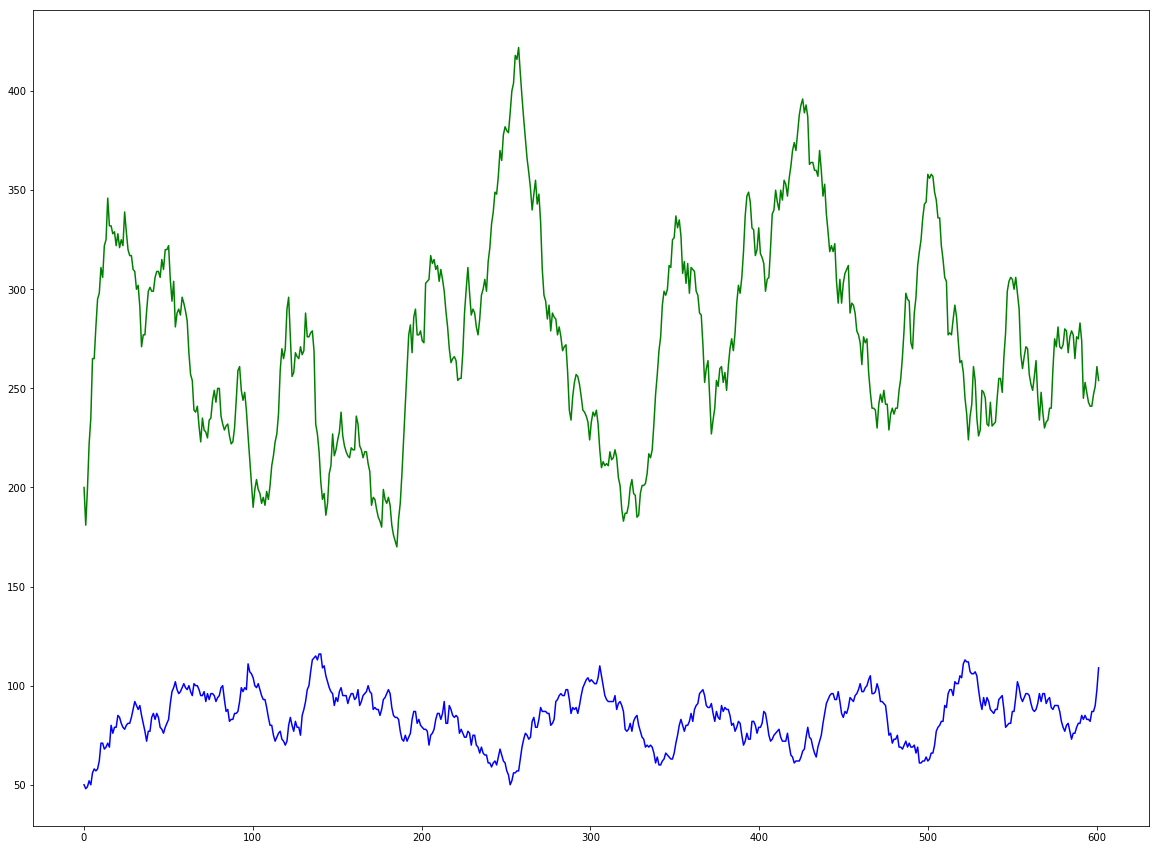

In [1276]:
x = np.linspace(0, len(lv.history[0]), len(lv.history[0]))
matplotlib.rcParams['figure.figsize'] = [20, 15]


plt.plot(x,lv.history[0],'g')
plt.plot(x,lv.history[1],'b')
#plt.plot(x,lv.history[2],'r')
#plt.plot(x,lv.history[3],'purple')
#plt.plot(x,lv.history[4],'orange')
#plt.plot(x,lv.history[5],'yellow')
#plt.plot(x,lv.history[6],'gray')
for h in range(len(lv.huntings)):
    plt.plot([lv.huntings[h],lv.huntings[h]],[0,lv.board.board_size**2],'k-',color='yellow', lw = 0.5)
plt.plot(lv.huntings,lv.huntedpr, 'x',color = 'red')
plt.show()

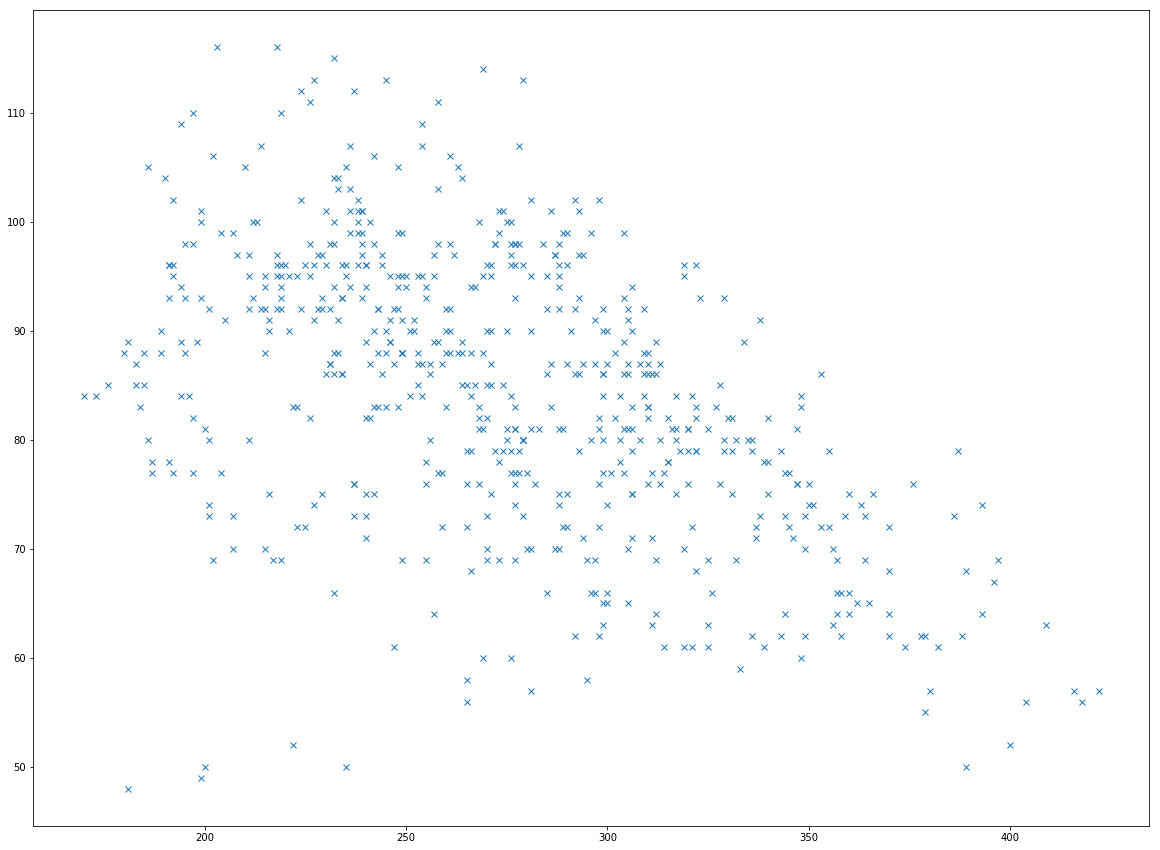

In [1277]:
#wykres fazowy
plt.plot(lv.history[0],lv.history[1],'x')
plt.show()

In [1209]:
lv.huntedpr

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 128,
 0,
 0,
 0,
 0,
 0,
 0,
 46,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 22,
 0,
 0,
 0,
 90,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 166,
 0,
 0,
 0,
 84,
 0,
 0,
 0,
 82,
 0,
 41,
 0,
 0,
 0,
 0,
 0,
 0,
 68,
 0,
 0,
 47,
 0,
 0,
 0,
 0,
 0,
 17,
 0,
 0,
 0,
 0,
 33,
 62,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 87,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 119,
 0,
 0,
 0,
 0,
 77,
 0,
 0,
 0,
 0,
 136,
 0,
 0,
 0,
 0,
 0,
 0,
 129,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 134,
 0,
 0,
 0,
 60,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 22,
 20,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 38,
 0,
 0,
 19,
 0,
 0,
 0,
 0,
 0,
 0,
 122,
 0,
 33,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 70,
 0,
 0,
 105,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [930]:
lv.step()

first:
 [[2 1 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
die:
 [[2 0 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
procreate:
 [[2 0 0 0 0]
 [2 0 2 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
2 [0, 0] na [4, 0]
2 [1, 2] na [2, 2]
2 [1, 0] na [0, 0]
move:
 [[2 0 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 0]
 [2 0 0 0 0]]
[0, 3, 0]


In [777]:
L = [np.array([]), np.array([[4, 0],
       [4, 2],
       [4, 3]]), np.array([[1, 0],
       [1, 4],
       [2, 0],
       [2, 4]])]
L = [l.tolist() for l in L]
LL = []
for x in L:
  for y in x:
    LL.append(y)
LL
#np.concatenate(L)

[[4, 0], [4, 2], [4, 3], [1, 0], [1, 4], [2, 0], [2, 4]]

In [ ]:
lv.board.compute_neighbours([1,2,3])

In [ ]:
np.transpose(np.nonzero(lv.board.board))

In [ ]:
lv.board.neighbours([1,2])

In [ ]:
lv.board.board

In [73]:
lv.board.compute_neighbours([1,2])

array([[1, 2, 0, 1, 1],
       [2, 2, 2, 2, 1],
       [3, 1, 3, 2, 2],
       [0, 3, 1, 2, 1],
       [1, 0, 1, 1, 0]])

In [361]:
for spec in range(len(lv.board.oecosystema), 0,  -1):#uwaga, liczone od tyłu!
        #prey = self.board.compute_neighbours()
            #coords = self.board.neighbours([spec+1])
        print(spec)

3
2
1


In [369]:
[1:4]+[4:7]

SyntaxError: invalid syntax (<ipython-input-369-615adaab4cbf>, line 1)

In [286]:
lv.check_neighbours([0,0])

[(0, 4, 2), (4, 0, 1)]

In [223]:
A = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0]])
B = np.array([[0,1,0],[1,0,1],[0,1,0]])

print(A)
print(scipy.signal.convolve2d(A,B,mode = 'same', boundary = 'wrap'))

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 0]]
[[0 2 0 1]
 [2 0 2 0]
 [0 2 0 1]
 [1 0 1 0]]


In [152]:
x=0
if not x:
    x=1
x

1

In [153]:
np.zeros((2,2), dtype = int)

array([[0, 0],
       [0, 0]])

In [243]:
b = Board(10,[7,10,5])

b.board

array([[2, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 2, 1, 3, 0, 0, 1],
       [0, 3, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
       [2, 0, 2, 0, 0, 2, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 1, 0, 2, 1, 0, 0, 0, 2, 0]])

In [155]:
b.monochromatic_board([1,3])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 0, 2, 2, 2, 2, 0, 2],
       [0, 2, 2, 0, 2, 2, 2, 2, 0, 0],
       [2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [147]:
A[A==1] = 2

In [266]:

np.random.randint( low = 0, high = 3, size = 10)

array([2, 1, 2, 2, 1, 0, 2, 1, 0, 2])

In [309]:
[c for c in range(5) if c not in [1,2,3]]

[0, 4]

In [161]:
B = np.array([[1,1,1],[1,0,1],[0,1,0]])

X = int(len(B)/2)
for x in B:
    Y = int(len(B[0])/2)
    for y in x:
        if(y):
            print((X,Y))
        Y-=1
    X-=1
        

(1, 1)
(1, 0)
(1, -1)
(0, 1)
(0, -1)
(-1, 0)


In [227]:
def unique(array, orderby='first'):
    array = np.asarray(array)
    order = array.argsort(kind='mergesort')
    array = array[order]
    diff = array[1:] != array[:-1]
    if orderby == 'first':
        diff = np.concatenate([[True], diff])
    elif orderby == 'last':
        diff = np.concatenate([diff, [True]])
    else:
        raise ValueError
    uniq = array[diff]
    index = order[diff]
    return uniq[index.argsort()]

In [239]:
N = 25
size = 5
coordinates = np.unique(np.random.randint(size, size = (N, 2)), axis = 0)
while coordinates.shape[0] < N:
    coordinates = np.unique(np.concatenate( (coordinates, np.random.randint(size, size = (1,2))),axis = 0),axis = 0)
np.random.shuffle(coordinates)
coordinates

array([[2, 0],
       [1, 2],
       [2, 1],
       [1, 4],
       [2, 3],
       [1, 3],
       [4, 2],
       [3, 0],
       [2, 4],
       [4, 1],
       [3, 4],
       [3, 1],
       [1, 1],
       [4, 4],
       [4, 3],
       [0, 4],
       [0, 3],
       [0, 0],
       [0, 2],
       [2, 2],
       [4, 0],
       [3, 2],
       [1, 0],
       [0, 1],
       [3, 3]])

In [234]:
coordinates

In [728]:
L = []
x = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
L.append(np.transpose(np.nonzero(x)).tolist())
L

[[[0, 0], [1, 1], [2, 0], [2, 1]]]

In [142]:
np.invert(np.invert(lv.board.board.astype(bool)))

array([[False,  True,  True, False,  True],
       [ True, False,  True,  True, False],
       [ True,  True,  True,  True, False],
       [False, False,  True,  True,  True],
       [False, False,  True, False,  True]])

In [80]:
pr = lv.predator
pry = []
for i in range(1,len(pr)+1):
    pryc = []
    for p in range(len(pr)):
        if i in pr[p]:
            pryc.append(p)
    pry.append(pryc)
pry

[[1, 2], [2], []]

In [291]:
a = np.array([[1,2,3],[0,0,0],[2,2,3]])
b = np.array([[2,0,2],[1,0,0],[0,0,2]]).astype(bool)
np.logical_and(a,b).astype(int)

array([[1, 0, 1],
       [0, 0, 0],
       [0, 0, 1]])

array([[1, 2, 3],
       [0, 0, 0],
       [2, 2, 3]])

In [213]:
np.logical_and(a,np.invert(b)).astype(int)

array([[0, 1, 0],
       [0, 0, 0],
       [1, 1, 0]])

In [252]:
([2,2]+[0,1])%3

TypeError: unsupported operand type(s) for %: 'list' and 'int'

In [337]:
a = [1,2,3,4]
b = np.random.binomial(1,0.7,4).astype(bool)
print(np.array(a)[np.array(b)])
print(b)

[1 4]
[ True False False  True]


In [647]:
np.concatenate([ [[1,2],[3,4]],[[45,12]] ]).tolist()

[[1, 2], [3, 4], [45, 12]]

In [649]:
[1,2] not in np.concatenate([ [[1,2],[3,4]],[[45,12]] ]).tolist()

False

In [301]:
c = coo_matrix(a)
print(c)

  (0, 0)	1
  (0, 1)	2
  (0, 2)	3
  (2, 0)	2
  (2, 1)	2
  (2, 2)	3


In [357]:
d = [[1,2],[3,4],[4,5]]
d[1][1]

4

In [409]:
np.random.randint(low=0,high=4, size = 50)

array([0, 2, 2, 3, 2, 0, 3, 3, 3, 0, 2, 3, 3, 0, 2, 2, 1, 1, 3, 3, 1, 0,
       1, 3, 3, 2, 1, 2, 0, 1, 3, 0, 3, 2, 0, 0, 3, 2, 1, 3, 2, 3, 1, 1,
       0, 1, 2, 3, 3, 3])

In [487]:
np.random.binomial(1,0.2,10).astype(bool)

array([False, False, False, False, False, False,  True, False, False,
       False])

In [633]:
[3,1] not in [[1,2],[23,2],[3,1]]

False

In [844]:
L[-1][-1]

[2, 4]

In [870]:
L = np.array([1,2])
list(L)

[1, 2]

In [871]:
list([1,2])

[1, 2]

In [1111]:
'normal' == 'normal'


True